In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import copy
import torch
import warnings
from torch_geometric.utils import lexsort
import os

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
def get_2D_ttc_circles_cuda_batched(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=np.sqrt(2),
    bubble=0,
    batch_size=None
):
    """
    Compute Time-To-Collision (TTC) using multiple-circle approximation with CUDA batch processing.
    Prevents CUDA OOM errors by processing in batches.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).
        batch_size: Number of samples per batch (auto-calculated if None).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    buffer_coef=(torch.tensor(buffer_coef, device='cuda'))
    # Move input tensors to the correct device
    ego_pos = ego_pos.to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.to(dtype=torch.float32, device=device)

    N = ego_pos.shape[0]

    # Auto-adjust batch size if not provided
    if batch_size is None:
        batch_size = min(500000, N)  # Default: 500K samples per batch
        batch_size = max(N, 1)

    num_batches = (N + batch_size - 1) // batch_size  # Compute number of batches
    ttc_results = torch.empty(N, device=device, dtype=torch.float32)  # Allocate space

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, N)

        # Slice batch
        ego_pos_batch = ego_pos[start_idx:end_idx]
        ego_vel_batch = ego_vel[start_idx:end_idx]
        ego_dim_batch = ego_dim[start_idx:end_idx]

        foe_pos_batch = foe_pos[start_idx:end_idx]
        foe_vel_batch = foe_vel[start_idx:end_idx]
        foe_dim_batch = foe_dim[start_idx:end_idx]

        # Compute TTC for batch
        ttc_batch = get_2D_ttc_circles_cuda(
            ego_pos_batch, ego_vel_batch, ego_dim_batch,
            foe_pos_batch, foe_vel_batch, foe_dim_batch,
            buffer_coef, bubble=bubble
        )

        # Store results
        ttc_results[start_idx:end_idx] = ttc_batch

    return ttc_results


def get_approximate_circles_cuda(pos, dim, device="cuda"):
    """
    Approximates a rectangular vehicle as a series of circles along its length.
    Returns a tensor of shape (N, max_circles, 2) containing circle centers.
    """
    x, y = pos[:, 0], pos[:, 1]
    L, W = dim[:, 0], dim[:, 1]

    # Number of circles (at least 1, up to L/W)
    num_circles = torch.ceil(L / W).to(torch.int32)

    max_circles = num_circles.max().item()

    # Compute x positions for circles
    start_x = x - L / 2 + W / 2
    end_x = x + L / 2 - W / 2
    step = (end_x - start_x) / (num_circles - 1).clamp(min=1)

    # Generate indices for evenly spaced circles
    indices = torch.arange(max_circles, device=device).unsqueeze(0)
    valid_mask = indices < num_circles.unsqueeze(1)

    # Compute circle positions
    x_positions = start_x.unsqueeze(1) + indices * step.unsqueeze(1)  # Shape: (N, max_circles)
    y_positions = y.unsqueeze(1).expand(-1, max_circles).clone()  # Keep y constant

    # Mask invalid circles
    x_positions[~valid_mask] = torch.nan
    y_positions[~valid_mask] = torch.nan

    return torch.stack([x_positions, y_positions], dim=-1)  # Shape: (N, max_circles, 2)

def get_2D_ttc_circles_cuda(
    ego_pos, ego_vel, ego_dim,
    foe_pos, foe_vel, foe_dim,
    buffer_coef=torch.sqrt(torch.tensor(2.0, device='cuda')),
    bubble=0
):
    """
    Compute Time-To-Collision (TTC) between vehicles approximated as multiple circles using CUDA acceleration.
    Assumes zero acceleration.
    
    Args:
        ego_pos: (N, 2) tensor - Ego vehicle positions (x, y).
        ego_vel: (N, 2) tensor - Ego vehicle velocities (Vx, Vy).
        ego_dim: (N, 2) tensor - Ego vehicle dimensions (Length, Width).
        foe_pos: (N, 2) tensor - Foe vehicle positions (x, y).
        foe_vel: (N, 2) tensor - Foe vehicle velocities (Vx, Vy).
        foe_dim: (N, 2) tensor - Foe vehicle dimensions (Length, Width).
        buffer_coef: Scaling factor for safety buffer (default sqrt(2)).

    Returns:
        ttc: (N,) tensor - Minimum Time-To-Collision values for each vehicle pair.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure tensors are on GPU
    ego_pos = ego_pos.clone().detach().to(dtype=torch.float32, device=device)
    ego_vel = ego_vel.clone().detach().to(dtype=torch.float32, device=device)
    ego_dim = ego_dim.clone().detach().to(dtype=torch.float32, device=device)

    foe_pos = foe_pos.clone().detach().to(dtype=torch.float32, device=device)
    foe_vel = foe_vel.clone().detach().to(dtype=torch.float32, device=device)
    foe_dim = foe_dim.clone().detach().to(dtype=torch.float32, device=device)

    # Compute circle centers for each vehicle
    ego_circles = get_approximate_circles_cuda(ego_pos, ego_dim, device)  # (N, C, 2)
    foe_circles = get_approximate_circles_cuda(foe_pos, foe_dim, device)  # (N, C, 2)

    # Compute circle radii based on vehicle width
    ego_r = (ego_dim[:, 1] / 2) * buffer_coef + bubble  # Shape: (N,)
    foe_r = (foe_dim[:, 1] / 2) * buffer_coef + bubble # Shape: (N,)
    total_r = ego_r.unsqueeze(1).unsqueeze(1) + foe_r.unsqueeze(1).unsqueeze(1)  # (N, 1, 1)

    # Compute all pairwise circle distances
    ego_exp = ego_circles.unsqueeze(2)  # (N, C, 1, 2)
    foe_exp = foe_circles.unsqueeze(1)  # (N, 1, C, 2)

    rel_pos = ego_exp - foe_exp  # Shape: (N, C, C, 2)
    rel_vel = ego_vel.unsqueeze(1).unsqueeze(1) - foe_vel.unsqueeze(1).unsqueeze(1)  # (N, 1, 1, 2)

    # Compute quadratic coefficients
    A = (rel_vel[..., 0]**2 + rel_vel[..., 1]**2)  # (N, C, C)
    B = 2 * (rel_pos[..., 0] * rel_vel[..., 0] + rel_pos[..., 1] * rel_vel[..., 1])  # (N, C, C)
    C = (rel_pos[..., 0]**2 + rel_pos[..., 1]**2 - total_r**2)  # (N, C, C)

    # Compute discriminant
    discriminant = B**2 - 4 * A * C
    # valid_mask = discriminant >= 0  # Valid solutions where discriminant is non-negative

    # sqrt_disc = torch.sqrt(torch.clamp(discriminant, min=0))  # Avoid NaNs

    sqrt_disc = torch.sqrt(discriminant)
    t1 = (-B + sqrt_disc) / (2 * A) 
    t2 = (-B - sqrt_disc) / (2 * A) 

    # Find the smallest positive TTC
    t1[t1 < 0] = float('inf')
    t2[t2 < 0] = float('inf')

    ttc = torch.min(t1, t2)  # Minimum positive solution for each circle pair

    # overlap mask 
    overlap_mask = C < 0
    ttc[overlap_mask] = 0
 
    # Handle invalid cases correctly
    ttc[torch.isnan(ttc)] = float('inf')  # Replace NaNs
    
    min_ttc = torch.amin(ttc, dim=(1, 2))  # Min over all circle interactions

    # Mask invalid results
    min_ttc = torch.clamp(min_ttc, max=1e9)  # Large value for "no collision"

    return min_ttc

In [4]:
def get_highd_interaction_pairs(data, batch_size=512):
    # interactionList = ['precedingId', 'followingId', 'leftPrecedingId', 'leftAlongsideId', 'leftFollowingId', 'rightPrecedingId', 'rightPrecedingId', 'rightAlongsideId', 'rightFollowingId']
    interactionList = ['precedingId', 'leftPrecedingId', 'leftAlongsideId', 'rightPrecedingId', 'rightPrecedingId', 'rightAlongsideId']
    unique_frames = data['frame'].unique()
    batched_frames = [unique_frames[i:i+batch_size] for i in range(0, len(unique_frames), batch_size)]
    # outer_indices = tracks.index.to_numpy()
    _ttcdata = np.zeros((len(data),16))
    Egos = []
    Foes = []
    # Process each batch
    for batch in batched_frames:
        batch_data = data[data['frame'].isin(batch)]
        # Process batch_data...
        surrs = torch.tensor(batch_data[interactionList].values, device='cuda', dtype=torch.int64)
        # Assuming tracks_tensor, frames, ids, and surrs are already defined
        frames = torch.tensor(batch_data['frame'].values, device='cuda', dtype=torch.int64)
        ids = torch.tensor(batch_data['id'].values, device='cuda', dtype=torch.int64)
        # Initialize the result tensor
        n = len(batch_data)
        s = torch.zeros((n,n), dtype=torch.float32)

        # Expand frames and ids for broadcasting
        frame_match = frames.unsqueeze(0) == frames.unsqueeze(1)  # Pairwise frame equality
        id_match = ids.unsqueeze(0).unsqueeze(2) == surrs.unsqueeze(1)  # Match ids with surrs

        # Combine the conditions
        matches = frame_match.unsqueeze(2) & id_match  # Shape: (num_tracks, num_tracks, max_surrs)

        # Reduce along the last dimension (surrs axis) to get a final match matrix
        s = matches.any(dim=2).to(torch.float32)

        ego_indices, foe_indices = torch.where(s)

        tracks_tensor = torch.tensor(batch_data.values, device='cuda')
        egos = tracks_tensor[ego_indices]
        foes = tracks_tensor[foe_indices]

        Egos.append(egos)
        Foes.append(foes)

    ego_data = torch.vstack(Egos)
    foe_data = torch.vstack(Foes)
    return ego_data, foe_data

In [5]:
def prepare_data_per_recording_2d(recording_id, distillframeinterval=5, lanechangewindow=25):
    tracks = pd.read_csv(f"E:/Data/highd-dataset-v1.0/data/{recording_id:02}_tracks.csv")
    distilled_frames = np.arange(tracks.frame.min(), tracks.frame.max(), distillframeinterval)
    distilled_tracks = tracks[tracks.frame.isin(distilled_frames)]
    # check if lane change will happen
    Pre_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
    Pos_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
    Pre_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
    Pos_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
    lanechangewindowframes = int(lanechangewindow / distillframeinterval)
    # get the direction indicator
    veh_mean_speed = distilled_tracks.groupby('id').xVelocity.transform('mean').values
    dir = (veh_mean_speed / np.abs(veh_mean_speed)).astype('int')
    distilled_tracks.loc[:,'_dir'] = dir
    distilled_tracks.loc[:,'_x'] = distilled_tracks.x + 0.5*distilled_tracks.width
    distilled_tracks.loc[:,'_y'] = distilled_tracks.y + 0.5*distilled_tracks.height

    # check if lane change happens
    for dt in range(1, lanechangewindowframes+1):
        pre_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pos_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pre_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        pos_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
        upper_mask = distilled_tracks._dir < 0
        lower_mask = distilled_tracks._dir > 0
        # differentiate left or right lane change
        left_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        right_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
        left_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
        right_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
        left_lanechange_mask = left_lanechange_mask_upper | left_lanechange_mask_lower
        right_lanechange_mask = right_lanechange_mask_upper | right_lanechange_mask_lower
        # get lc indicators
        pre_left_lc_mask[:-dt] = left_lanechange_mask
        pos_left_lc_mask[dt:] = left_lanechange_mask
        Pre_LC_L += pre_left_lc_mask
        Pos_LC_L += pos_left_lc_mask

        pre_right_lc_mask[:-dt] = right_lanechange_mask
        pos_right_lc_mask[dt:] = right_lanechange_mask
        Pre_LC_R += pre_right_lc_mask
        Pos_LC_R += pos_right_lc_mask

    # get the lane changing indicator
    distilled_tracks.loc[:,'preLeftLaneChange'] = Pre_LC_L.astype(int)
    distilled_tracks.loc[:,'posLeftLaneChange'] = Pos_LC_L.astype(int)
    distilled_tracks.loc[:,'preRightLaneChange'] = Pre_LC_R.astype(int)
    distilled_tracks.loc[:,'posRightLaneChange'] = Pos_LC_R.astype(int)

    def count_in_range(x_array, r=50):
        # Create a 2D difference matrix (each element |x_i - x_j|)
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        # For each row, count how many differences are <= r.
        return (diff_matrix <= r).sum(axis=1)

    # Apply the function for each frame using groupby-transform:
    vehicle_counts_nearby = distilled_tracks.groupby(["frame","_dir"])["_x"].transform(lambda s: count_in_range(s.values, r=1e8))
    # Get segment length
    segment_length = distilled_tracks.x.max() - distilled_tracks.x.min()
    neighbor_nlanes = distilled_tracks.groupby("_dir").laneId.transform('nunique').values
    # get nearby densities
    neighbor_densities = vehicle_counts_nearby / segment_length / neighbor_nlanes * 1000

    def compute_mean_velocity_for_group(group, r=5):
        # Get arrays for x positions and xVelocity
        x_array = group["x"].values
        vel_array = group["xVelocity"].values
        
        # Compute pairwise absolute differences in x positions via broadcasting
        diff_matrix = np.abs(x_array[:, None] - x_array[None, :])
        
        # Boolean mask: True when difference is within r
        in_range_mask = diff_matrix <= r
        
        # For each row, compute the mean xVelocity of vehicles in range
        mean_vel = (in_range_mask * vel_array[None, :]).sum(axis=1) / in_range_mask.sum(axis=1)
        return mean_vel

    def compute_mean_velocity_for_all(df, r=5):
        """
        Compute, for each row in df, the mean of xVelocity for nearby vehicles (|x_i - x|<=r) in the same frame.
        Returns a Series with the same index as df.
        """
        # Group by frame; each group contains vehicles in that frame.
        # For each group, compute mean velocities and return a Series with the same index as the group.
        grouped_series = df.groupby(["frame","_dir"], group_keys=False).apply(
            lambda group: pd.Series(compute_mean_velocity_for_group(group, r), index=group.index)
        )
        # Reindex to ensure the order matches df exactly
        return grouped_series.reindex(df.index)

    # Compute the mean xVelocity for nearby vehicles for each row,
    # ensuring that the output Series has the same order as df.
    mean_vel_series = compute_mean_velocity_for_all(distilled_tracks, r=1e8)

    distilled_tracks['localVelocity'] = mean_vel_series.abs().values
    distilled_tracks['localDensity'] = neighbor_densities

    # ego data -- the following vehicle data
    # foe data -- the leading vehicle data
    ego_, foe_ = get_highd_interaction_pairs(distilled_tracks, batch_size=64)
    (frame_ids, ego_ids, ego_xs, ego_ys, ego_length, ego_width, ego_xVel, ego_yVel, ego_xAccel, ego_yAccel) = ego_[:,0:10].split(1, dim=1)
    (frame_ids, foe_ids, foe_xs, foe_ys, foe_length, foe_width, foe_xVel, foe_yVel, foe_xAccel, foe_yAccel) = foe_[:,0:10].split(1, dim=1)

    ego_pos = torch.cat([ego_xs+0.5*ego_length, ego_ys+0.5*ego_width], dim=1)
    ego_vel = torch.cat([ego_xVel, ego_yVel], dim=1)
    ego_accel = torch.cat([ego_xAccel, ego_yAccel], dim=1)
    ego_dim = torch.cat([ego_length, ego_width], dim=1)

    foe_pos = torch.cat([foe_xs+0.5*foe_length, foe_ys+0.5*foe_width], dim=1)
    foe_vel = torch.cat([foe_xVel, foe_yVel], dim=1)
    foe_accel = torch.cat([foe_xAccel, foe_yAccel], dim=1)
    foe_dim = torch.cat([foe_length, foe_width], dim=1)

    ttcs = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=1.000, bubble=0.2) 

    ego_data = pd.DataFrame(ego_.cpu().numpy(), columns=distilled_tracks.columns)
    foe_data = pd.DataFrame(foe_.cpu().numpy(), columns=distilled_tracks.columns)

    del ego_, foe_

    # we need these variables
    ego_vel = ego_data.xVelocity.abs().values
    foe_vel = foe_data.xVelocity.abs().values

    ego_accel = ego_data.xAcceleration.values * ego_data._dir.values
    foe_accel = foe_data.xAcceleration.values * foe_data._dir.values

    ego_pre_leftLc = ego_data.preLeftLaneChange.values
    ego_pos_leftLc = ego_data.posLeftLaneChange.values
    ego_pre_rightLc = ego_data.preRightLaneChange.values
    ego_pos_rightLc = ego_data.posRightLaneChange.values
    foe_pre_leftLc = foe_data.preLeftLaneChange.values
    foe_pos_leftLc = foe_data.posLeftLaneChange.values
    foe_pre_rightLc = foe_data.preRightLaneChange.values
    foe_pos_rightLc = foe_data.posRightLaneChange.values

    ego_length = ego_data.width.values
    foe_length = foe_data.width.values

    original_ttc = copy.deepcopy(ego_data.ttc.values)
    original_ttc[original_ttc <=0] = np.inf

    ego_localspeed = ego_data.localVelocity.values
    foe_localspeed = foe_data.localVelocity.values

    ego_localdensity = ego_data.localDensity.values
    foe_localdensity = foe_data.localDensity.values

    recordingIds = np.full(len(ego_data), recording_id)

    egoIds = ego_data.id.values
    foeIds = foe_data.id.values

    frameIds = ego_data.frame.values

    dataframe = pd.DataFrame(data={
        'ego_vel': ego_vel,
        'foe_vel': foe_vel,
        'ego_accel': ego_accel,
        'foe_accel': foe_accel,
        'ego_pre_left_lc': ego_pre_leftLc,
        'foe_pre_left_lc': foe_pre_leftLc,
        'ego_pos_left_lc': ego_pos_leftLc,
        'foe_pos_left_lc': foe_pos_leftLc,
        'ego_pre_right_lc': ego_pre_rightLc,
        'foe_pre_right_lc': foe_pre_rightLc,
        'ego_pos_right_lc': ego_pos_rightLc,
        'foe_pos_right_lc': foe_pos_rightLc,
        'ego_local_speed': ego_localspeed,
        'foe_local_speed': foe_localspeed,
        'ego_local_density': ego_localdensity,
        'foe_local_density': foe_localdensity,
        'ego_length': ego_length,
        'foe_length': foe_length,
        'recording_id': recordingIds,
        'ego_id': egoIds,
        'foe_id': foeIds,
        'frame': frameIds,
        'dir': ego_data._dir.values,
        'ttc': ttcs.cpu().numpy(),
        'ottc': original_ttc,
    })

    return dataframe

In [6]:
def process_highd_interaction_risk_dataset(record_range, distillframeinterval=5, lanechangewindow=25):
    warnings.filterwarnings('ignore')
    DataFrames = [ prepare_data_per_recording_2d(record, distillframeinterval, lanechangewindow=lanechangewindow) for record in tqdm(record_range)  ]
    return pd.concat(DataFrames, ignore_index=True).reset_index()

In [7]:
def compute_time_until_next_ttc_below_threshold_vectorized(data, threshold=1.5, batch_size=500):
    """
    Compute the time (frames) until the next occurrence of `TTC < threshold` for each unique 
    ego-foe interaction (defined by ego_id, foe_id, recording_id).

    If the current row already has `TTC < threshold`, return 0.

    Args:
        data: (N, 5) tensor - Columns: [ego_id, foe_id, recording_id, frame_id, ttc]
        threshold: float - TTC threshold (default 1.5 seconds).
        batch_size: int - Number of unique (ego_id, foe_id, recording_id) pairs processed at once.

    Returns:
        time_until_next_ttc_below: (N,) tensor - Time until next TTC < threshold for each row, 
                                              in the original input order.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move data to GPU if available
    data = data.to(device)

    # Save original indices to restore order later
    original_indices = torch.arange(data.shape[0], device=device)

    # Extract columns
    ego_id, foe_id, recording_id, frame_id, ttc = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]

    # ✅ Step 1: Correct Multi-Column Sorting
    # Sorting by (ego_id, foe_id, recording_id, frame_id)
    sorted_indices = lexsort((frame_id, recording_id, foe_id, ego_id))

    # Apply sorting
    ego_id, foe_id, recording_id, frame_id, ttc, original_indices = (
        ego_id[sorted_indices], foe_id[sorted_indices], recording_id[sorted_indices],
        frame_id[sorted_indices], ttc[sorted_indices], original_indices[sorted_indices]
    )

    # ✅ Step 2: Identify Unique (ego_id, foe_id, recording_id) Pairs
    unique_pairs, pair_indices = torch.unique(
        torch.stack([ego_id, foe_id, recording_id], dim=1),
        dim=0, return_inverse=True
    )

    num_pairs = unique_pairs.shape[0]  # Total unique pairs
    num_batches = (num_pairs + batch_size - 1) // batch_size  # Compute number of batches

    # ✅ Step 3: Identify All Frames Where `TTC < threshold`
    below_threshold_mask = ttc < threshold  # Boolean mask where TTC < threshold
    valid_frame_ids = frame_id[below_threshold_mask]  # Frames where `TTC < threshold`
    valid_pair_indices = pair_indices[below_threshold_mask]  # Matching pair indices

    # Initialize the result tensor
    time_until_next_ttc_below = torch.full_like(frame_id, float('inf'), device=device)

    # ✅ Step 4: Process in Batches to Reduce Memory Usage
    for batch_idx in trange(num_batches):
        # Get the current batch of pairs
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_pairs)
        batch_pair_indices = torch.arange(start_idx, end_idx, device=device)

        # Get mask for rows belonging to this batch
        batch_mask = (pair_indices >= start_idx) & (pair_indices < end_idx)

        if batch_mask.sum() == 0:  # Skip if no data in batch
            continue

        # Get the frame_ids of the current batch
        batch_frame_ids = frame_id[batch_mask]

        # Get the valid events that belong to this batch
        batch_valid_mask = (valid_pair_indices >= start_idx) & (valid_pair_indices < end_idx)
        batch_valid_frame_ids = valid_frame_ids[batch_valid_mask]
        batch_valid_pair_indices = valid_pair_indices[batch_valid_mask]

        if batch_valid_frame_ids.numel() == 0:  # Skip empty batches
            continue

        # Compute `valid_frame_ids - frame_id` in a batched, vectorized manner
        all_time_diffs = batch_valid_frame_ids.unsqueeze(0) - batch_frame_ids.unsqueeze(1)  # (batch_size, num_valid_events)
        all_time_diffs[all_time_diffs <= 0] = float('inf')  # Ignore past events  

        # ✅ Step 5: Ensure we only consider valid pairs
        pair_match_mask = pair_indices[batch_mask].unsqueeze(1) == batch_valid_pair_indices.unsqueeze(0)  # Shape: (batch_size, num_valid_events)
        all_time_diffs[~pair_match_mask] = float('inf')  # Mask invalid pairs

        # Compute the minimum valid time difference per row
        min_time_diffs, _ = all_time_diffs.min(dim=1)

        # ✅ Step 6: Assign results back
        time_until_next_ttc_below[batch_mask] = min_time_diffs

    # ✅ Step 7: Post-processing
    # If the row itself is `TTC < threshold`, set time until next to `0`
    time_until_next_ttc_below[below_threshold_mask] = 0

    # If no future `TTC < threshold` exists, set time to `-1`
    time_until_next_ttc_below[time_until_next_ttc_below == float('inf')] = -1

    # ✅ Step 8: Restore Original Order
    restored_order = torch.argsort(original_indices)  # Get indices that map back to the original order
    time_until_next_ttc_below = time_until_next_ttc_below[restored_order]  # Restore order

    return time_until_next_ttc_below

def compute_transitions_vectorized_mode_1(data, thres1=1.5, thres2=3.0, device='cuda'):
    data = torch.tensor(data, device=device)

    ttc1 = compute_time_until_next_ttc_below_threshold_vectorized(data[:,(0,1,2,3,4)], threshold=thres1, batch_size=1000)
    ttc2 = compute_time_until_next_ttc_below_threshold_vectorized(data[:,(0,1,2,3,5)], threshold=thres2, batch_size=1000)

    # Step 1: Extract columns
    ego_id, foe_id, recording_id, frame_id = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    original_indices = torch.arange(data.shape[0], device=device)
    sorted_indices = lexsort((frame_id, recording_id, foe_id, ego_id))
    
    # Apply sorting
    ego_id, foe_id, recording_id, frame_id, original_indices, ttc1, ttc2 = (
        ego_id[sorted_indices], foe_id[sorted_indices], recording_id[sorted_indices],
        frame_id[sorted_indices], original_indices[sorted_indices], ttc1[sorted_indices], ttc2[sorted_indices]
    )

    # Step 2: Find unique (ego_id, foe_id, recording_id) groups
    unique_pairs, pair_indices = torch.unique(torch.stack([ego_id, foe_id, recording_id], dim=1), dim=0, return_inverse=True)

    states = torch.full_like(ttc1, 3, dtype=torch.int32, device='cuda')  # Default is state 3
    states[ttc2 == 0] = 2  # If TTC < 5, but not < 1.5
    states[ttc1 == 0] = 1  # If TTC < 1.5, override to state 1

    state_changes = (states[1:] != states[:-1])*(pair_indices[1:] == pair_indices[:-1])
    transition_indices = torch.where(state_changes)[0] + 1  # Convert to indices (offset by 1)
    
    first_frames_per_group = torch.full_like(frame_id, float('inf'))  # Initialize with large values
    first_frames_per_group = first_frames_per_group.scatter_reduce_(0, pair_indices, frame_id, reduce="amin")[:len(unique_pairs)]

    first_transition_per_group = torch.full((pair_indices.max() + 1,), torch.iinfo(torch.long).max, dtype=torch.long, device=transition_indices.device)

    # Step 3: Scatter reduce to find the first transition index per group
    first_transition_per_group.scatter_reduce_(0, pair_indices[transition_indices], transition_indices, reduce="amin")

    # Step 4: Compare transition indices with the first transition per group
    first_transition_mask = transition_indices == first_transition_per_group[pair_indices[transition_indices]]

    # Step 5: 
    n_transitions = len(transition_indices)
    transition_from_states = states[transition_indices-1]
    transition_to_states = states[transition_indices]
    transition_start_frames = torch.cat([torch.tensor([0], device=device), frame_id[transition_indices[0:n_transitions-1]]])
    transition_start_frames = transition_start_frames*~first_transition_mask + first_transition_mask*first_frames_per_group[pair_indices[transition_indices]]
    transition_end_frames = frame_id[transition_indices[0:n_transitions]] 

    transitions = torch.stack([ego_id[transition_indices], foe_id[transition_indices], recording_id[transition_indices], transition_start_frames, transition_end_frames, transition_from_states, transition_to_states], dim=1)
    return transitions


In [70]:
dataset = process_highd_interaction_risk_dataset(range(1,61), distillframeinterval=5, lanechangewindow=125)

100%|██████████| 60/60 [02:19<00:00,  2.33s/it]


In [9]:
dataset.to_csv('./data/highd_surv_dataset_2d.csv')

In [8]:
dataset = pd.read_csv('./data/highd_surv_dataset_2d.csv', index_col=0)

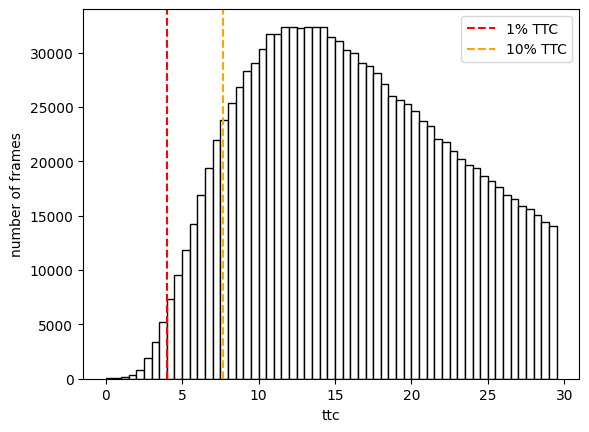

In [9]:
ttcUpBound = 30
plt.hist(dataset.ttc, np.arange(0,ttcUpBound,0.5), fc='white', ec='black')
ttclevel1 = np.percentile(dataset.ttc[dataset.ttc<ttcUpBound], 1.0)
ttclevel2 = np.percentile(dataset.ttc[dataset.ttc<ttcUpBound], 10.0)
plt.ylabel('number of frames')
plt.xlabel('ttc')
plt.axvline(ttclevel1, color='red', linestyle='dashed', label='1% TTC')
plt.axvline(ttclevel2, color='orange', linestyle='dashed', label='10% TTC')
plt.legend()


In [10]:
_data = dataset[['ego_id','foe_id','recording_id','frame','ttc','ttc']].values
tensor = torch.tensor(_data, device='cuda')
transitions_tensor = compute_transitions_vectorized_mode_1(tensor, thres1=3.0, thres2=7.5)
transitions_df = pd.DataFrame(transitions_tensor.cpu().numpy(), columns=['ego_id','foe_id','recording_id','start','end','from','to'])

C:\Users\Lucas\AppData\Local\Temp\ipykernel_27292\3414999733.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, device=device)
100%|██████████| 435/435 [00:01<00:00, 342.38it/s]


In [11]:
dataset

,index,ego_vel,foe_vel,ego_accel,foe_accel,ego_pre_left_lc,foe_pre_left_lc,ego_pos_left_lc,foe_pos_left_lc,ego_pre_right_lc,...,foe_local_density,ego_length,foe_length,recording_id,ego_id,foe_id,frame,dir,ttc,ottc
0,0,32.10,38.62,0.27,0.61,0.0,0.0,0.0,0.0,0.0,...,7.019350,4.24,5.66,1,2.0,13.0,6.0,-1.0,1.000000e+09,inf
1,1,32.16,38.75,0.27,0.65,0.0,0.0,0.0,0.0,0.0,...,7.019350,4.24,5.66,1,2.0,13.0,11.0,-1.0,1.000000e+09,inf
2,2,32.21,38.88,0.25,0.67,0.0,0.0,0.0,0.0,0.0,...,7.019350,4.24,5.66,1,2.0,13.0,16.0,-1.0,1.000000e+09,inf
3,3,32.26,39.02,0.21,0.68,0.0,0.0,0.0,0.0,0.0,...,7.019350,4.24,5.66,1,2.0,13.0,21.0,-1.0,1.000000e+09,inf
4,4,32.30,39.16,0.18,0.69,0.0,0.0,0.0,0.0,0.0,...,7.019350,4.24,5.66,1,2.0,13.0,26.0,-1.0,1.000000e+09,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17256258,17256258,35.12,45.49,0.28,-0.03,0.0,0.0,0.0,0.0,0.0,...,7.703745,4.45,4.45,60,1467.0,1454.0,24006.0,1.0,1.000000e+09,inf
17256259,17256259,35.12,34.23,0.28,0.25,0.0,0.0,0.0,0.0,0.0,...,7.703745,4.45,4.95,60,1467.0,1465.0,24006.0,1.0,1.000000e+09,inf
17256260,17256260,35.17,34.28,0.28,0.25,0.0,0.0,0.0,0.0,0.0,...,6.933370,4.45,4.95,60,1467.0,1465.0,24011.0,1.0,1.000000e+09,inf
17256261,17256261,35.23,34.33,0.28,0.25,0.0,0.0,0.0,0.0,0.0,...,6.933370,4.45,4.95,60,1467.0,1465.0,24016.0,1.0,1.000000e+09,inf


In [12]:
def get_processed_input_start_stop(data, transition, sequence=250, from_state=2, to_state=1, truck_thres=10, accel_thres=0.67, density_norm=50, speed_norm=45, device='cuda'):
    transition = transition[ (transition['from']==from_state)&(transition['to']==to_state) ]  if from_state != None and to_state != None else transition # only process certain transitions
    Tran = torch.tensor(transition.values, device=device)
    # get ego, foe vehicle class
    ego_class = np.asarray(data.ego_length.values > truck_thres).astype(int)
    foe_class = np.asarray(data.foe_length.values > truck_thres).astype(int)
    # get ego, foe acceleration status
    ego_accel = np.zeros(len(data))
    ego_decel = np.zeros(len(data))
    ego_accel[data.ego_accel > accel_thres] = 1
    ego_decel[data.ego_accel < -accel_thres] = 1
    foe_accel = np.zeros(len(data))
    foe_decel = np.zeros(len(data))
    foe_accel[data.foe_accel > accel_thres] = 1
    foe_decel[data.foe_accel < -accel_thres] = 1
    # get ego, foe lc status
    ego_pre_left_lc = data.ego_pre_left_lc.values
    ego_pre_right_lc = data.ego_pre_right_lc.values
    ego_pos_left_lc = data.ego_pos_left_lc.values
    ego_pos_right_lc = data.ego_pos_right_lc.values

    foe_pre_left_lc = data.foe_pre_left_lc.values
    foe_pre_right_lc = data.foe_pre_right_lc.values
    foe_pos_left_lc = data.foe_pos_left_lc.values
    foe_pos_right_lc = data.foe_pos_right_lc.values

    # get ego, foe local density
    ego_local_density = np.asarray(data.ego_local_density.values > density_norm).astype(int)
    # get ego, foe local speed
    ego_local_speed = np.asarray(data.ego_local_speed.values < speed_norm).astype(int)
    # near a ramp?
    ramp = np.asarray( (data.recording_id.isin([58,59,60]))&(data.dir==-1) ).astype(int)
    # get ego id
    _ego = data.ego_id.values
    # get foe id
    _foe = data.foe_id.values
    # get record
    _record = data.recording_id.values
    #
    # get frame
    _frame = data.frame.values
    data = np.array(
    [
        ego_pre_left_lc, ego_pre_right_lc, ego_pos_left_lc, ego_pos_right_lc, foe_pre_left_lc, foe_pre_right_lc, foe_pos_left_lc, foe_pos_right_lc, ego_accel, ego_decel, foe_accel, foe_decel, ego_class, foe_class, ego_local_density, ego_local_speed, ramp, _ego, _foe, _record, _frame
    ]
    ).T
    # np.nan_to_num(data, 0)
    data = torch.tensor(data, device=device, dtype=torch.float)

    _ego = data[:,-4]
    _foe = data[:,-3]
    _record = data[:,-2]
    _frames = data[:,-1]

    n_features = data.shape[1]
    n_sequance = int(sequence/5)
    
    # get the input data
    _Data = torch.torch.full((len(Tran), n_sequance, n_features), float('nan'), device='cuda')
    for m in trange(len(Tran)):
        ego, foe, record, start, end, _from, to = Tran[m]
        _start = torch.max(end - (n_sequance-1)*5, start)
        mask = ((_frames.unsqueeze(1) >= (_start)) & (_frames.unsqueeze(1) <= end) & (_ego.unsqueeze(1)==ego) &  (_foe.unsqueeze(1)==foe) & (_record.unsqueeze(1)==record)   ).any(dim=1)
        indices = (-(end-_frames[mask])/ 5 ).to(torch.int) - 1
        _Data[m][indices] = data[mask]
    return _Data

In [13]:
def get_start_stop_input_transitions(data, _transition, window=250, sequence=250, from_state=None, to_state=None, truck_thres=10, accel_thres=0.67, density_norm=50, speed_norm=45, device='cuda'):
    # get intermediate input
    _input = get_processed_input_start_stop(data, _transition, sequence=sequence, from_state=from_state, to_state=to_state, truck_thres=truck_thres, accel_thres=accel_thres, density_norm=density_norm, speed_norm=speed_norm, device=device)
    valid_mask = (_transition.end - _transition.start) < 250
    transition = _transition[valid_mask]
    _input = _input[valid_mask]
    # process the input data
    ChunkList = []
    print ( "-- Generating start stop data -- ")
    for i in trange(_input.shape[0]):
        row = _input[i]
        dur = transition.iloc[i]
        transition_mask = ~torch.isnan(row).any(dim=1)
        transition_data = row[transition_mask]
        transition_frames = transition_data[:,-1]
        group_ids = ((transition_frames - transition_frames[0]) // window).long()
        max_g = max(group_ids)
        group_counts = torch.bincount(group_ids)
        for g in group_ids.unique():
            chunk = transition_data[group_ids == g]
            chunkdata = chunk[0]
            # tenure
            tenure = torch.tensor([g * window], device=chunkdata.device)
            # transition duration
            past = torch.tensor([window], device=chunkdata.device) if g < max_g else torch.tensor([group_counts[-1]*5], device=chunkdata.device)
            # from 
            _from = torch.tensor([dur['from']], device=chunkdata.device) 
            # to
            _to = _from if g < max_g else torch.tensor([dur['to']], device=chunkdata.device)

            new_row = torch.cat([chunkdata, tenure, past, _from, _to])
            ChunkList.append(new_row)
    Chunks = torch.vstack(ChunkList)
    return Chunks

In [ ]:
input = get_start_stop_input_transitions(dataset, transitions_df, window=250, density_norm=35, speed_norm=35)

100%|██████████| 24808/24808 [00:38<00:00, 639.22it/s]


-- Generating start stop data -- 


100%|██████████| 23015/23015 [00:48<00:00, 478.67it/s]


In [15]:
input[:,-4].sum()

tensor(0., device='cuda:0', dtype=torch.float64)

Cox-PH -- Cause-Specific (C-S)

In [16]:
from lifelines import CoxPHFitter

In [17]:
covariate_names = [
    'ego_pre_left_lc',
    'ego_pre_right_lc',
    'ego_pos_left_lc',
    'ego_pos_right_lc',
    'foe_pre_left_lc',
    'foe_pre_right_lc',
    'foe_pos_left_lc',
    'foe_pos_right_lc',
    'ego_accel',
    'ego_decel',
    'foe_accel',
    'foe_decel',
    'ego_class',
    'foe_class',
    'ego_local_density',
    'ego_local_speed',
    'ramp'
]
num_covariates = len(covariate_names)

In [18]:
esc_mask = (input[:,-2]==2)&(input[:,-1]==1)
esc_duration = input[esc_mask][:,-3]/5
esc_input = input[esc_mask][:,:num_covariates]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input[:,-2]==2)&(input[:,-1]==3)
desc_duration = input[desc_mask][:,-3]/5
desc_input = input[desc_mask][:,:num_covariates]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input[:,-2]==2)&(input[:,-1]==2)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([esc_duration, desc_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = torch.concatenate([esc_input, desc_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]



Cox-PH Risky-->Near-Crash

In [19]:
# create the survival dataframe
surv1 = pd.DataFrame(data=covariate, columns=covariate_names)
surv1['duration'] = duration
surv1['event_cause1'] = np.asarray(event == 1).astype(int)
cph_cs1 = CoxPHFitter()
cph_cs1.fit(surv1, duration_col='duration', event_col='event_cause1')
cph_cs1.print_summary()

<lifelines.CoxPHFitter: fitted with 13108 total observations, 12611 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
      baseline estimation = breslow
   number of observations = 13108
number of events observed = 497
   partial log-likelihood = -4217.40
         time fit was run = 2025-06-16 19:59:01 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
ego_pre_left_lc   -0.64      0.53      0.22           -1.08           -0.21                0.34                0.81
ego_pre_right_lc  -0.17      0.85      0.58           -1.30            0.97                0.27                2.64
ego_pos_left_lc    0.38      1.46      0.34           -0.29            1.05                0.75                2.86
ego_pos_right_lc   0.84      2.32      0.12            0.61            1.07                1.85                2.91
foe_pre_left_lc    0.73      2.08      0.22            0.30            1.17                1.35                3.23
foe_pre_right_lc  -0.61      0.54      1.00           -2.58            1.35                0.08                3.86
foe_pos_left_lc    0.64      1.89      0.17            0.31            0.96                1.37                2.62
foe_pos_right_lc   1.50      4.49      0.29            0.94            2.07                2.55                7.89
ego_accel          0.52      1.68      0.30           -0.06            1.10                0.94                2.99
ego_decel         -1.11      0.33      0.19           -1.49           -0.73                0.22                0.48
foe_accel          0.52      1.69      0.35           -0.16            1.21                0.85                3.35
foe_decel          0.80      2.21      0.16            0.48            1.11                1.62                3.04
ego_class          0.34      1.41      0.17            0.01            0.67                1.01                1.95
foe_class          0.67      1.96      0.10            0.48            0.87                1.61                2.38
ego_local_density  0.35      1.41      0.19           -0.02            0.71                0.98                2.04
ego_local_speed   -0.18      0.84      0.36           -0.88            0.52                0.41                1.69
ramp               0.82      2.27      0.18            0.46            1.18                1.58                3.27

                   cmp to     z      p  -log2(p)
covariate                                       
ego_pre_left_lc      0.00 -2.89 <0.005      8.01
ego_pre_right_lc     0.00 -0.29   0.77      0.37
ego_pos_left_lc      0.00  1.11   0.27      1.90
ego_pos_right_lc     0.00  7.22 <0.005     40.80
foe_pre_left_lc      0.00  3.29 <0.005      9.95
foe_pre_right_lc     0.00 -0.61   0.54      0.89
foe_pos_left_lc      0.00  3.83 <0.005     12.95
foe_pos_right_lc     0.00  5.22 <0.005     22.40
ego_accel            0.00  1.75   0.08      3.64
ego_decel            0.00 -5.72 <0.005     26.46
foe_accel            0.00  1.49   0.14      2.88
foe_decel            0.00  4.95 <0.005     20.34
ego_class            0.00  2.03   0.04      4.58
foe_class            0.00  6.74 <0.005     35.91
ego_local_density    0.00  1.85   0.06      3.94
ego_local_speed      0.00 -0.50   0.62      0.70
ramp                 0.00  4.44 <0.005     16.75
---
Concordance = 0.69
Partial AIC = 8468.81
log-likelihood ratio test = 220.98 on 17 df
-log2(p) of ll-ratio test = 122.17

Cox-PH Risky --> Safe

In [20]:
# create the survival dataframe
surv2 = pd.DataFrame(data=covariate, columns=covariate_names)
surv2['duration'] = duration
surv2['event_cause2'] = np.asarray(event == 2).astype(int)
cph_cs2 = CoxPHFitter()
cph_cs2.fit(surv2, duration_col='duration', event_col='event_cause2')
cph_cs2.print_summary()

<lifelines.CoxPHFitter: fitted with 13108 total observations, 497 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause2'
      baseline estimation = breslow
   number of observations = 13108
number of events observed = 12611
   partial log-likelihood = -106343.28
         time fit was run = 2025-06-16 19:59:12 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
ego_pre_left_lc    0.07      1.08      0.03            0.01            0.14                1.01                1.15
ego_pre_right_lc   0.02      1.02      0.09           -0.15            0.20                0.86                1.22
ego_pos_left_lc    0.04      1.04      0.08           -0.12            0.19                0.89                1.21
ego_pos_right_lc  -0.23      0.79      0.03           -0.29           -0.17                0.75                0.84
foe_pre_left_lc   -0.37      0.69      0.05           -0.48           -0.27                0.62                0.76
foe_pre_right_lc   0.36      1.44      0.10            0.16            0.57                1.17                1.76
foe_pos_left_lc   -0.31      0.74      0.04           -0.38           -0.23                0.68                0.80
foe_pos_right_lc   0.27      1.30      0.10            0.07            0.46                1.07                1.59
ego_accel          0.41      1.51      0.07            0.28            0.55                1.33                1.73
ego_decel         -0.12      0.89      0.03           -0.18           -0.06                0.83                0.94
foe_accel          0.34      1.40      0.09            0.17            0.50                1.18                1.65
foe_decel         -0.64      0.53      0.04           -0.72           -0.57                0.49                0.56
ego_class          0.07      1.07      0.04           -0.00            0.15                1.00                1.16
foe_class          0.18      1.19      0.02            0.14            0.22                1.15                1.24
ego_local_density -0.43      0.65      0.05           -0.52           -0.34                0.59                0.71
ego_local_speed   -0.05      0.95      0.07           -0.18            0.08                0.83                1.08
ramp              -0.16      0.85      0.05           -0.27           -0.05                0.76                0.95

                   cmp to      z      p  -log2(p)
covariate                                        
ego_pre_left_lc      0.00   2.33   0.02      5.67
ego_pre_right_lc     0.00   0.27   0.79      0.34
ego_pos_left_lc      0.00   0.48   0.63      0.67
ego_pos_right_lc     0.00  -7.80 <0.005     47.22
foe_pre_left_lc      0.00  -6.89 <0.005     37.38
foe_pre_right_lc     0.00   3.51 <0.005     11.11
foe_pos_left_lc      0.00  -7.70 <0.005     46.11
foe_pos_right_lc     0.00   2.64   0.01      6.91
ego_accel            0.00   6.23 <0.005     30.96
ego_decel            0.00  -3.76 <0.005     12.55
foe_accel            0.00   3.95 <0.005     13.65
foe_decel            0.00 -17.26 <0.005    219.35
ego_class            0.00   1.93   0.05      4.22
foe_class            0.00   9.32 <0.005     66.26
ego_local_density    0.00  -8.95 <0.005     61.32
ego_local_speed      0.00  -0.81   0.42      1.25
ramp                 0.00  -2.94 <0.005      8.24
---
Concordance = 0.60
Partial AIC = 212720.56
log-likelihood ratio test = 1146.14 on 17 df
-log2(p) of ll-ratio test = 771.80

cox-PH Cause-specific safe-->risky

In [21]:
risk_mask = (input[:,-2]==3)&(input[:,-1]==2)
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:num_covariates]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==3)&(input[:,-1]==3)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

# create the survival dataframe
surv3 = pd.DataFrame(data=covariate, columns=covariate_names)
surv3['duration'] = duration
surv3['event'] = np.asarray(event == 1).astype(int)
cph_cs3 = CoxPHFitter()
cph_cs3.fit(surv3, duration_col='duration', event_col='event')
cph_cs3.print_summary()

<lifelines.CoxPHFitter: fitted with 9250 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 9250
number of events observed = 9250
   partial log-likelihood = -74969.33
         time fit was run = 2025-06-16 19:59:14 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
ego_pre_left_lc    0.27      1.31      0.06            0.16            0.38                1.17                1.46
ego_pre_right_lc  -0.06      0.94      0.08           -0.23            0.10                0.80                1.10
ego_pos_left_lc    0.53      1.69      0.10            0.33            0.73                1.39                2.07
ego_pos_right_lc   0.97      2.64      0.05            0.86            1.08                2.37                2.93
foe_pre_left_lc    0.52      1.67      0.06            0.40            0.63                1.49                1.89
foe_pre_right_lc  -0.11      0.90      0.10           -0.31            0.09                0.73                1.10
foe_pos_left_lc    0.51      1.67      0.06            0.39            0.63                1.47                1.89
foe_pos_right_lc  -0.27      0.76      0.12           -0.51           -0.03                0.60                0.97
ego_accel         -0.01      0.99      0.07           -0.15            0.12                0.86                1.13
ego_decel          0.17      1.18      0.05            0.07            0.26                1.07                1.30
foe_accel          0.01      1.01      0.11           -0.20            0.23                0.82                1.26
foe_decel          0.23      1.25      0.05            0.13            0.33                1.13                1.39
ego_class         -0.10      0.90      0.04           -0.19           -0.01                0.83                0.99
foe_class          0.10      1.10      0.02            0.05            0.14                1.06                1.15
ego_local_density -0.23      0.80      0.08           -0.38           -0.08                0.69                0.92
ego_local_speed   -0.21      0.81      0.07           -0.35           -0.06                0.71                0.94
ramp               0.23      1.26      0.06            0.11            0.36                1.12                1.43

                   cmp to     z      p  -log2(p)
covariate                                       
ego_pre_left_lc      0.00  4.84 <0.005     19.55
ego_pre_right_lc     0.00 -0.76   0.45      1.16
ego_pos_left_lc      0.00  5.19 <0.005     22.15
ego_pos_right_lc     0.00 17.86 <0.005    234.53
foe_pre_left_lc      0.00  8.49 <0.005     55.38
foe_pre_right_lc     0.00 -1.06   0.29      1.79
foe_pos_left_lc      0.00  8.06 <0.005     50.27
foe_pos_right_lc     0.00 -2.19   0.03      5.12
ego_accel            0.00 -0.19   0.85      0.23
ego_decel            0.00  3.42 <0.005     10.65
foe_accel            0.00  0.13   0.89      0.16
foe_decel            0.00  4.43 <0.005     16.69
ego_class            0.00 -2.29   0.02      5.50
foe_class            0.00  4.45 <0.005     16.81
ego_local_density    0.00 -3.01 <0.005      8.58
ego_local_speed      0.00 -2.82 <0.005      7.68
ramp                 0.00  3.72 <0.005     12.28
---
Concordance = 0.57
Partial AIC = 149972.66
log-likelihood ratio test = 521.32 on 17 df
-log2(p) of ll-ratio test = 329.59

cox-PH Cause-specific Near-Crash-->Risky

In [56]:
risk_mask = (input[:,-2]==1)&(input[:,-1]==2)
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:num_covariates]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==1)&(input[:,-1]==1)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

# create the survival dataframe
surv4 = pd.DataFrame(data=covariate, columns=covariate_names)
surv4['duration'] = duration
surv4['event'] = np.asarray(event == 1).astype(int)
cph_cs4 = CoxPHFitter()
cph_cs4.fit(surv4, duration_col='duration', event_col='event')
cph_cs4.print_summary()

<lifelines.CoxPHFitter: fitted with 287 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 287
number of events observed = 287
   partial log-likelihood = -1284.54
         time fit was run = 2025-06-12 15:29:08 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
ego_pre_left_lc    0.73      2.08      1.09           -1.40            2.87                0.25               17.69
ego_pre_right_lc   0.21      1.23      0.73           -1.23            1.64                0.29                5.16
ego_pos_left_lc   -0.32      0.72      0.44           -1.18            0.53                0.31                1.70
ego_pos_right_lc   0.01      1.01      0.17           -0.32            0.33                0.73                1.39
foe_pre_left_lc    0.11      1.11      0.42           -0.72            0.94                0.49                2.55
foe_pre_right_lc   0.15      1.16      0.74           -1.30            1.60                0.27                4.97
foe_pos_left_lc   -0.34      0.71      0.24           -0.82            0.14                0.44                1.15
foe_pos_right_lc   0.06      1.06      0.32           -0.58            0.70                0.56                2.01
ego_accel          1.46      4.31      0.60            0.29            2.63                1.34               13.91
ego_decel         -1.20      0.30      0.21           -1.60           -0.80                0.20                0.45
foe_accel         -0.05      0.95      0.32           -0.67            0.58                0.51                1.78
foe_decel         -0.19      0.83      0.24           -0.66            0.27                0.52                1.32
ego_class          0.04      1.04      0.21           -0.37            0.46                0.69                1.58
foe_class         -0.16      0.85      0.15           -0.44            0.13                0.64                1.14
ego_local_density -0.58      0.56      0.22           -1.01           -0.15                0.37                0.86
ego_local_speed    1.76      5.83      0.86            0.09            3.44                1.09               31.17
ramp               0.56      1.75      0.38           -0.17            1.30                0.84                3.67

                   cmp to     z      p  -log2(p)
covariate                                       
ego_pre_left_lc      0.00  0.67   0.50      1.00
ego_pre_right_lc     0.00  0.28   0.78      0.36
ego_pos_left_lc      0.00 -0.74   0.46      1.12
ego_pos_right_lc     0.00  0.04   0.97      0.05
foe_pre_left_lc      0.00  0.25   0.80      0.32
foe_pre_right_lc     0.00  0.21   0.84      0.26
foe_pos_left_lc      0.00 -1.40   0.16      2.62
foe_pos_right_lc     0.00  0.18   0.86      0.23
ego_accel            0.00  2.45   0.01      6.11
ego_decel            0.00 -5.84 <0.005     27.47
foe_accel            0.00 -0.15   0.88      0.19
foe_decel            0.00 -0.81   0.42      1.25
ego_class            0.00  0.20   0.84      0.25
foe_class            0.00 -1.08   0.28      1.83
ego_local_density    0.00 -2.63   0.01      6.86
ego_local_speed      0.00  2.06   0.04      4.67
ramp                 0.00  1.49   0.13      2.89
---
Concordance = 0.72
Partial AIC = 2603.08
log-likelihood ratio test = 112.96 on 17 df
-log2(p) of ll-ratio test = 51.41

In [23]:
esc_mask_1 = (input[:,-2]==3)&(input[:,-1]==1)
esc_duration_1 = input[esc_mask_1][:,-3]/5
esc_input_1 = input[esc_mask_1][:,:num_covariates]
esc_label_1 = np.full(len(esc_input_1), 1)

esc_mask_2 = (input[:,-2]==3)&(input[:,-1]==2)
esc_duration_2 = input[esc_mask_2][:,-3]/5
esc_input_2 = input[esc_mask_2][:,:num_covariates]
esc_label_2 = np.full(len(esc_input_2), 2)

censor_mask = (input[:,-2]==3)&(input[:,-1]==3)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([esc_duration_1, esc_duration_2, censor_duration]).cpu().numpy()
_event = np.concatenate([esc_label_1, esc_label_2, censor_label])
_covariate = torch.concatenate([esc_input_1, esc_input_2, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]



In [28]:
# create the survival dataframe
surv32 = pd.DataFrame(data=covariate, columns=covariate_names)
surv32['duration'] = duration
surv32['event_cause1'] = np.asarray(event == 2).astype(int)
cph_cs31 = CoxPHFitter()
cph_cs31.fit(surv32, duration_col='duration', event_col='event_cause1')
cph_cs31.print_summary()

<lifelines.CoxPHFitter: fitted with 595 total observations, 287 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
      baseline estimation = breslow
   number of observations = 595
number of events observed = 308
   partial log-likelihood = -1583.50
         time fit was run = 2025-06-16 20:08:30 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ego_pre_left_lc     1.46      4.31      0.22            1.03            1.89                2.81                6.61
ego_pre_right_lc    0.99      2.70      0.61           -0.20            2.18                0.82                8.87
ego_pos_left_lc     0.17      1.19      0.27           -0.37            0.71                0.69                2.03
ego_pos_right_lc   -0.01      0.99      0.15           -0.31            0.29                0.73                1.33
foe_pre_left_lc    -1.76      0.17      0.45           -2.64           -0.88                0.07                0.42
foe_pre_right_lc  -13.88      0.00   1680.66        -3307.92         3280.17                0.00                 inf
foe_pos_left_lc     0.18      1.20      0.18           -0.18            0.54                0.84                1.71
foe_pos_right_lc    0.06      1.06      0.34           -0.61            0.72                0.55                2.06
ego_accel           0.81      2.25      0.35            0.12            1.50                1.12                4.50
ego_decel          -2.23      0.11      0.33           -2.88           -1.59                0.06                0.20
foe_accel          -0.34      0.71      0.31           -0.94            0.26                0.39                1.30
foe_decel          -0.20      0.82      0.34           -0.87            0.46                0.42                1.59
ego_class           0.22      1.25      0.18           -0.14            0.58                0.87                1.78
foe_class          -0.27      0.77      0.13           -0.51           -0.02                0.60                0.98
ego_local_density  -1.69      0.18      0.46           -2.59           -0.80                0.08                0.45
ego_local_speed    -0.28      0.75      0.40           -1.08            0.51                0.34                1.66
ramp                0.35      1.42      0.17            0.02            0.68                1.02                1.98

                   cmp to     z      p  -log2(p)
covariate                                       
ego_pre_left_lc      0.00  6.71 <0.005     35.54
ego_pre_right_lc     0.00  1.64   0.10      3.30
ego_pos_left_lc      0.00  0.62   0.54      0.90
ego_pos_right_lc     0.00 -0.07   0.94      0.09
foe_pre_left_lc      0.00 -3.91 <0.005     13.38
foe_pre_right_lc     0.00 -0.01   0.99      0.01
foe_pos_left_lc      0.00  0.98   0.33      1.61
foe_pos_right_lc     0.00  0.17   0.86      0.21
ego_accel            0.00  2.29   0.02      5.50
ego_decel            0.00 -6.76 <0.005     36.11
foe_accel            0.00 -1.10   0.27      1.88
foe_decel            0.00 -0.60   0.55      0.86
ego_class            0.00  1.21   0.23      2.13
foe_class            0.00 -2.13   0.03      4.90
ego_local_density    0.00 -3.70 <0.005     12.21
ego_local_speed      0.00 -0.70   0.48      1.05
ramp                 0.00  2.08   0.04      4.75
---
Concordance = 0.72
Partial AIC = 3200.99
log-likelihood ratio test = 232.19 on 17 df
-log2(p) of ll-ratio test = 129.73

In [27]:
desc_mask_1 = (input[:,-2]==1)&(input[:,-1]==2)
desc_duration_1 = input[desc_mask_1][:,-3]/5
desc_input_1 = input[desc_mask_1][:,:num_covariates]
desc_label_1 = np.full(len(desc_input_1), 1)

desc_mask_2 = (input[:,-2]==1)&(input[:,-1]==3)
desc_duration_2 = input[desc_mask_2][:,-3]/5
desc_input_2 = input[desc_mask_2][:,:num_covariates]
desc_label_2 = np.full(len(desc_input_2), 2)

censor_mask = (input[:,-2]==1)&(input[:,-1]==1)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([desc_duration_1, desc_duration_2, censor_duration]).cpu().numpy()
_event = np.concatenate([desc_label_1, desc_label_2, censor_label])
_covariate = torch.concatenate([desc_input_1, desc_input_2, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]



In [29]:
# create the survival dataframe
surv12 = pd.DataFrame(data=covariate, columns=covariate_names)
surv12['duration'] = duration
surv12['event_cause1'] = np.asarray(event == 1).astype(int)
cph_cs31 = CoxPHFitter()
cph_cs31.fit(surv12, duration_col='duration', event_col='event_cause1')
cph_cs31.print_summary()

<lifelines.CoxPHFitter: fitted with 595 total observations, 308 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
      baseline estimation = breslow
   number of observations = 595
number of events observed = 287
   partial log-likelihood = -1518.16
         time fit was run = 2025-06-16 20:08:42 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
ego_pre_left_lc   -2.86      0.06      1.01           -4.84           -0.88                0.01                0.41
ego_pre_right_lc  -0.09      0.92      0.72           -1.50            1.33                0.22                3.77
ego_pos_left_lc   -0.51      0.60      0.42           -1.33            0.32                0.26                1.37
ego_pos_right_lc  -0.19      0.83      0.15           -0.49            0.11                0.61                1.12
foe_pre_left_lc    0.01      1.01      0.36           -0.70            0.72                0.50                2.06
foe_pre_right_lc   0.59      1.80      0.73           -0.85            2.02                0.43                7.54
foe_pos_left_lc   -0.56      0.57      0.24           -1.03           -0.09                0.36                0.91
foe_pos_right_lc   0.29      1.34      0.33           -0.35            0.94                0.71                2.55
ego_accel         -0.48      0.62      0.59           -1.64            0.68                0.19                1.97
ego_decel         -0.20      0.82      0.19           -0.58            0.18                0.56                1.20
foe_accel          0.25      1.28      0.29           -0.33            0.82                0.72                2.28
foe_decel         -0.35      0.70      0.25           -0.84            0.14                0.43                1.15
ego_class          0.03      1.03      0.21           -0.37            0.44                0.69                1.55
foe_class          0.04      1.04      0.14           -0.23            0.31                0.79                1.37
ego_local_density  0.02      1.02      0.23           -0.44            0.48                0.65                1.62
ego_local_speed    1.19      3.28      0.76           -0.29            2.67                0.75               14.44
ramp              -1.30      0.27      0.36           -2.02           -0.59                0.13                0.56

                   cmp to     z      p  -log2(p)
covariate                                       
ego_pre_left_lc      0.00 -2.83 <0.005      7.76
ego_pre_right_lc     0.00 -0.12   0.90      0.15
ego_pos_left_lc      0.00 -1.20   0.23      2.13
ego_pos_right_lc     0.00 -1.23   0.22      2.20
foe_pre_left_lc      0.00  0.03   0.97      0.04
foe_pre_right_lc     0.00  0.80   0.42      1.25
foe_pos_left_lc      0.00 -2.34   0.02      5.71
foe_pos_right_lc     0.00  0.90   0.37      1.45
ego_accel            0.00 -0.81   0.42      1.26
ego_decel            0.00 -1.02   0.31      1.71
foe_accel            0.00  0.84   0.40      1.31
foe_decel            0.00 -1.41   0.16      2.66
ego_class            0.00  0.16   0.87      0.19
foe_class            0.00  0.30   0.76      0.39
ego_local_density    0.00  0.09   0.92      0.11
ego_local_speed      0.00  1.57   0.12      3.11
ramp                 0.00 -3.57 <0.005     11.44
---
Concordance = 0.64
Partial AIC = 3070.32
log-likelihood ratio test = 59.21 on 17 df
-log2(p) of ll-ratio test = 19.43

In [31]:
# create the survival dataframe
surv13 = pd.DataFrame(data=covariate, columns=covariate_names)
surv13['duration'] = duration
surv13['event_cause1'] = np.asarray(event == 2).astype(int)
cph_cs13 = CoxPHFitter()
cph_cs13.fit(surv13, duration_col='duration', event_col='event_cause1')
cph_cs13.print_summary()

<lifelines.CoxPHFitter: fitted with 595 total observations, 287 right-censored observations>
             duration col = 'duration'
                event col = 'event_cause1'
      baseline estimation = breslow
   number of observations = 595
number of events observed = 308
   partial log-likelihood = -1583.50
         time fit was run = 2025-06-16 20:12:58 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ego_pre_left_lc     1.46      4.31      0.22            1.03            1.89                2.81                6.61
ego_pre_right_lc    0.99      2.70      0.61           -0.20            2.18                0.82                8.87
ego_pos_left_lc     0.17      1.19      0.27           -0.37            0.71                0.69                2.03
ego_pos_right_lc   -0.01      0.99      0.15           -0.31            0.29                0.73                1.33
foe_pre_left_lc    -1.76      0.17      0.45           -2.64           -0.88                0.07                0.42
foe_pre_right_lc  -13.88      0.00   1680.66        -3307.92         3280.17                0.00                 inf
foe_pos_left_lc     0.18      1.20      0.18           -0.18            0.54                0.84                1.71
foe_pos_right_lc    0.06      1.06      0.34           -0.61            0.72                0.55                2.06
ego_accel           0.81      2.25      0.35            0.12            1.50                1.12                4.50
ego_decel          -2.23      0.11      0.33           -2.88           -1.59                0.06                0.20
foe_accel          -0.34      0.71      0.31           -0.94            0.26                0.39                1.30
foe_decel          -0.20      0.82      0.34           -0.87            0.46                0.42                1.59
ego_class           0.22      1.25      0.18           -0.14            0.58                0.87                1.78
foe_class          -0.27      0.77      0.13           -0.51           -0.02                0.60                0.98
ego_local_density  -1.69      0.18      0.46           -2.59           -0.80                0.08                0.45
ego_local_speed    -0.28      0.75      0.40           -1.08            0.51                0.34                1.66
ramp                0.35      1.42      0.17            0.02            0.68                1.02                1.98

                   cmp to     z      p  -log2(p)
covariate                                       
ego_pre_left_lc      0.00  6.71 <0.005     35.54
ego_pre_right_lc     0.00  1.64   0.10      3.30
ego_pos_left_lc      0.00  0.62   0.54      0.90
ego_pos_right_lc     0.00 -0.07   0.94      0.09
foe_pre_left_lc      0.00 -3.91 <0.005     13.38
foe_pre_right_lc     0.00 -0.01   0.99      0.01
foe_pos_left_lc      0.00  0.98   0.33      1.61
foe_pos_right_lc     0.00  0.17   0.86      0.21
ego_accel            0.00  2.29   0.02      5.50
ego_decel            0.00 -6.76 <0.005     36.11
foe_accel            0.00 -1.10   0.27      1.88
foe_decel            0.00 -0.60   0.55      0.86
ego_class            0.00  1.21   0.23      2.13
foe_class            0.00 -2.13   0.03      4.90
ego_local_density    0.00 -3.70 <0.005     12.21
ego_local_speed      0.00 -0.70   0.48      1.05
ramp                 0.00  2.08   0.04      4.75
---
Concordance = 0.72
Partial AIC = 3200.99
log-likelihood ratio test = 232.19 on 17 df
-log2(p) of ll-ratio test = 129.73

CoxPH -- Cumulative Incidence Function (CIF)

In [57]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.4.1"
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, numpy2ri
import cmprsk

In [58]:
# Activate automatic conversion between pandas DataFrames and R data.frames
numpy2ri.activate()
pandas2ri.activate()

In [59]:
esc_mask = (input[:,-2]==2)&(input[:,-1]==1)
esc_duration = input[esc_mask][:,-3]/5
esc_input = input[esc_mask][:,:num_covariates]
esc_label = np.full(len(esc_input), 1)

desc_mask = (input[:,-2]==2)&(input[:,-1]==3)
desc_duration = input[desc_mask][:,-3]/5
desc_input = input[desc_mask][:,:num_covariates]
desc_label = np.full(len(desc_input), 2)

censor_mask = (input[:,-2]==2)&(input[:,-1]==2)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([esc_duration, desc_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([esc_label, desc_label, censor_label])
_covariate = torch.concatenate([esc_input, desc_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

event1 = event
event2 = np.where(event == 1, 2, np.where(event == 2, 1, event))


DATA = pd.DataFrame(data=covariate, columns=covariate_names)
DATA['duration'] = duration
DATA['event1'] = event1
DATA['event2'] = event2
# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data"] = pandas2ri.py2rpy(DATA)

Risky --> Near-Crash (Cox-PH CIF)

In [61]:
# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data[, c('ego_pre_left_lc',
    'ego_pre_right_lc',
    'ego_pos_left_lc',
    'ego_pos_right_lc',
    'foe_pre_left_lc',
    'foe_pre_right_lc',
    'foe_pos_left_lc',
    'foe_pos_right_lc',
    'ego_accel',
    'ego_decel',
    'foe_accel',
    'foe_decel',
    'ego_class',
    'foe_class',
    'ego_local_density',
    'ego_local_speed',
    'ramp')])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model <- crr(ftime = data$duration, fstatus = data$event1, cov1 = covariates)

# Output the summary of the model
summary(fg_model)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary = robjects.r("summary(fg_model)")
# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix = np.array(fg_summary.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary = pd.DataFrame(
    {"covariate_name": covariate_names, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)
print (result_summary)

Shape of fg_coef_matrix: (17, 5)
Log-test information (model fitness): [243.59275398  17.        ]
Model Convergence: True
       covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0     ego_pre_left_lc      0.504049     0.328714     0.772907  1.700000e-03
1    ego_pre_right_lc      0.816672     0.258633     2.578766  7.300000e-01
2     ego_pos_left_lc      1.325187     0.670591     2.618765  4.200000e-01
3    ego_pos_right_lc      2.765718     2.207379     3.465284  0.000000e+00
4     foe_pre_left_lc      2.775811     1.793607     4.295884  4.600000e-06
5    foe_pre_right_lc      0.443095     0.062936     3.119574  4.100000e-01
6     foe_pos_left_lc      2.279595     1.635805     3.176756  1.100000e-06
7    foe_pos_right_lc      3.194998     1.804586     5.656705  6.700000e-05
8           ego_accel      1.408497     0.785468     2.525708  2.500000e-01
9           ego_decel      0.367040     0.243825     0.552521  1.600000e-06
10          foe_accel      1.371197     0

Risky --> Safe (Cox-PH CIF)

In [62]:
# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data[, c('ego_pre_left_lc',
    'ego_pre_right_lc',
    'ego_pos_left_lc',
    'ego_pos_right_lc',
    'foe_pre_left_lc',
    'foe_pre_right_lc',
    'foe_pos_left_lc',
    'foe_pos_right_lc',
    'ego_accel',
    'ego_decel',
    'foe_accel',
    'foe_decel',
    'ego_class',
    'foe_class',
    'ego_local_density',
    'ego_local_speed',
    'ramp')])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model <- crr(ftime = data$duration, fstatus = data$event2, cov1 = covariates)

# Output the summary of the model
summary(fg_model)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary = robjects.r("summary(fg_model)")
# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix = np.array(fg_summary.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary = pd.DataFrame(
    {"covariate_name": covariate_names, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)
print (result_summary)

Shape of fg_coef_matrix: (17, 5)
Log-test information (model fitness): [786.69695043  17.        ]
Model Convergence: True
       covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0     ego_pre_left_lc      1.083621     1.028588     1.141598  2.500000e-03
1    ego_pre_right_lc      0.992685     0.855696     1.151606  9.200000e-01
2     ego_pos_left_lc      0.959842     0.816140     1.128846  6.200000e-01
3    ego_pos_right_lc      0.702201     0.664038     0.742557  0.000000e+00
4     foe_pre_left_lc      0.700522     0.634935     0.772884  1.300000e-12
5    foe_pre_right_lc      1.338782     1.146326     1.563550  2.300000e-04
6     foe_pos_left_lc      0.714923     0.665316     0.768229  0.000000e+00
7    foe_pos_right_lc      0.930607     0.727086     1.191095  5.700000e-01
8           ego_accel      1.299382     1.114963     1.514304  8.000000e-04
9           ego_decel      0.981693     0.930002     1.036257  5.000000e-01
10          foe_accel      1.145068     0

In [64]:
risk_mask = (input[:,-2]==3)&(input[:,-1]==2)
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:num_covariates]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==3)&(input[:,-1]==3)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

covariate_names = [
    'ego_pre_left_lc',
    'ego_pre_right_lc',
    'ego_pos_left_lc',
    'ego_pos_right_lc',
    'foe_pre_left_lc',
    'foe_pre_right_lc',
    'foe_pos_left_lc',
    'foe_pos_right_lc',
    'ego_accel',
    'ego_decel',
    'foe_accel',
    'foe_decel',
    'ego_class',
    'foe_class',
    'ego_local_density',
    'ego_local_speed',
    'ramp'
]
DATA = pd.DataFrame(data=covariate, columns=covariate_names)
DATA['duration'] = duration
DATA['event'] = event

# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data_4"] = pandas2ri.py2rpy(DATA)

# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data_4[, c('ego_pre_left_lc',
    'ego_pre_right_lc',
    'ego_pos_left_lc',
    'ego_pos_right_lc',
    'foe_pre_left_lc',
    'foe_pre_right_lc',
    'foe_pos_left_lc',
    'foe_pos_right_lc',
    'ego_accel',
    'ego_decel',
    'foe_accel',
    'foe_decel',
    'ego_class',
    'foe_class',
    'ego_local_density',
    'ego_local_speed',
    'ramp')])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model_4 <- crr(ftime = data_4$duration, fstatus = data_4$event, cov1 = covariates)

# Output the summary of the model
summary(fg_model_4)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary_4 = robjects.r("summary(fg_model_4)")

# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix_4 = np.array(fg_summary_4.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix_4[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix_4[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix_4[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix_4[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary_4.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary_4.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary_4.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary_4.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary_4 = pd.DataFrame(
    {"covariate_name": covariate_names, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)


print (result_summary_4)



Shape of fg_coef_matrix: (17, 5)
Log-test information (model fitness): [491.67211357  17.        ]
Model Convergence: True
       covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0     ego_pre_left_lc      1.306538     1.128918     1.512104  3.400000e-04
1    ego_pre_right_lc      0.942716     0.814359     1.091303  4.300000e-01
2     ego_pos_left_lc      1.663221     1.412808     1.958018  9.900000e-10
3    ego_pos_right_lc      2.558162     2.227100     2.938438  0.000000e+00
4     foe_pre_left_lc      1.647710     1.456874     1.863542  1.800000e-15
5    foe_pre_right_lc      0.894138     0.752893     1.061882  2.000000e-01
6     foe_pos_left_lc      1.640274     1.417103     1.898590  3.300000e-11
7    foe_pos_right_lc      0.776936     0.609785     0.989904  4.100000e-02
8           ego_accel      0.989213     0.863004     1.133881  8.800000e-01
9           ego_decel      1.172441     1.072852     1.281274  4.400000e-04
10          foe_accel      1.016221     0

In [65]:
risk_mask = (input[:,-2]==1)&(input[:,-1]==2)
risk_duration = input[risk_mask][:,-3]/5
risk_input = input[risk_mask][:,:num_covariates]
risk_label = np.full(len(risk_mask), 1)

censor_mask = (input[:,-2]==1)&(input[:,-1]==1)
censor_duration = input[censor_mask][:,-3]/5
censor_input = input[censor_mask][:,:num_covariates]
censor_label = np.full(len(censor_input), 0)

_duration = torch.concatenate([risk_duration, censor_duration]).cpu().numpy()
_event = np.concatenate([risk_label, censor_label])
_covariate = torch.concatenate([risk_input, censor_input]).cpu().numpy()
# shuffle 
_keys = np.arange(len(_duration))
np.random.shuffle(_keys)
duration = _duration[_keys]
event = _event[_keys]
covariate = _covariate[_keys]

covariate_names = [
    'ego_pre_left_lc',
    'ego_pre_right_lc',
    'ego_pos_left_lc',
    'ego_pos_right_lc',
    'foe_pre_left_lc',
    'foe_pre_right_lc',
    'foe_pos_left_lc',
    'foe_pos_right_lc',
    'ego_accel',
    'ego_decel',
    'foe_accel',
    'foe_decel',
    'ego_class',
    'foe_class',
    'ego_local_density',
    'ego_local_speed',
    'ramp'
]
DATA = pd.DataFrame(data=covariate, columns=covariate_names)
DATA['duration'] = duration
DATA['event'] = event

# Transfer the pandas DataFrame to R’s global environment
robjects.globalenv["data_1"] = pandas2ri.py2rpy(DATA)

# Define and run R code to load cmprsk and fit the Fine–Gray model:
r_code = """
# Load the required library
library(cmprsk)

# Define the covariate matrix (adjust column names as needed)
covariates <- as.matrix(data_1[, c('ego_pre_left_lc',
    'ego_pre_right_lc',
    'ego_pos_left_lc',
    'ego_pos_right_lc',
    'foe_pre_left_lc',
    'foe_pre_right_lc',
    'foe_pos_left_lc',
    'foe_pos_right_lc',
    'ego_accel',
    'ego_decel',
    'foe_accel',
    'foe_decel',
    'ego_class',
    'foe_class',
    'ego_local_density',
    'ego_local_speed',
    'ramp')])

# Fit the Fine-Gray Model for the event of interest (event code = 1)
fg_model_1 <- crr(ftime = data_1$duration, fstatus = data_1$event, cov1 = covariates)

# Output the summary of the model
summary(fg_model_1)
"""
# Execute the R code from Python
result = robjects.r(r_code)
# obtained a summary:
fg_summary_1 = robjects.r("summary(fg_model_1)")

# --- 1. Extract the coefficients matrix from the fg_summary
# This matrix should have one row per covariate and columns: 
#   [coef, exp(coef), se, z, p-value]
fg_coef_matrix_1 = np.array(fg_summary_1.rx2("coef"))
# For clarity, you can check its shape and column names (if available)
print("Shape of fg_coef_matrix:", fg_coef_matrix.shape)

# --- 2. Retrieve the individual components
# Raw coefficients (log hazard ratios)
coef = fg_coef_matrix_1[:, 0]

# Hazard Ratios (exp(coef)); should be the same as column 2
hazard_ratios = fg_coef_matrix_1[:, 1]

# Standard errors (of the coefficients)
se = fg_coef_matrix_1[:, 2]

# Two-sided p-values
p_values = fg_coef_matrix_1[:, 4]

# --- 3. Compute 95% Confidence Intervals for the Hazard Ratios
# Lower bound = exp(coef - 1.96*se)
# Upper bound = exp(coef + 1.96*se)
lower_bounds = np.array(fg_summary_1.rx2("conf.int"))[:,2]
upper_bounds = np.array(fg_summary_1.rx2("conf.int"))[:,3]

# --- 4. Retrieve Model Fitness Information from 'logtest'
# For many crr models, "logtest" might contain the test statistic and degrees of freedom.
logtest = np.array(fg_summary_1.rx2("logtest"))
# For example, if logtest has two elements, they may represent [Test Statistic, Degrees of Freedom]
print("Log-test information (model fitness):", logtest)

# --- 5. Check Convergence
# "converged" indicates whether the algorithm converged.
convergence = fg_summary_1.rx2("converged")[0]
print("Model Convergence:", convergence)

result_summary_1 = pd.DataFrame(
    {"covariate_name": covariate_names, "hazard_ratio": hazard_ratios, "lower_bound": lower_bounds, "upper_bound": upper_bounds, "p_values": p_values}
)


print (result_summary_1)



Shape of fg_coef_matrix: (17, 5)
Log-test information (model fitness): [89.91133671 17.        ]
Model Convergence: True
       covariate_name  hazard_ratio  lower_bound  upper_bound      p_values
0     ego_pre_left_lc      1.737336     0.855680     3.527412  1.300000e-01
1    ego_pre_right_lc      1.225387     0.456766     3.287399  6.900000e-01
2     ego_pos_left_lc      0.741081     0.411624     1.334230  3.200000e-01
3    ego_pos_right_lc      0.997820     0.779246     1.277702  9.900000e-01
4     foe_pre_left_lc      1.089969     0.546239     2.174931  8.100000e-01
5    foe_pre_right_lc      1.145041     0.819434     1.600030  4.300000e-01
6     foe_pos_left_lc      0.740132     0.477277     1.147750  1.800000e-01
7    foe_pos_right_lc      1.038425     0.605123     1.781995  8.900000e-01
8           ego_accel      2.993954     1.783457     5.026058  3.300000e-05
9           ego_decel      0.342716     0.231411     0.507558  9.100000e-08
10          foe_accel      0.946758     0.6

In [85]:
recording_id = 3
distillframeinterval = 5
lanechangewindow = 125

In [86]:
tracks = pd.read_csv(f"E:/Data/highd-dataset-v1.0/data/{recording_id:02}_tracks.csv")
distilled_frames = np.arange(tracks.frame.min(), tracks.frame.max(), distillframeinterval)
distilled_tracks = tracks[tracks.frame.isin(distilled_frames)]
# check if lane change will happen
Pre_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
Pos_LC_L = np.zeros(len(distilled_tracks), dtype=bool)
Pre_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
Pos_LC_R = np.zeros(len(distilled_tracks), dtype=bool)
lanechangewindowframes = int(lanechangewindow / distillframeinterval)
# get the direction indicator
veh_mean_speed = distilled_tracks.groupby('id').xVelocity.transform('mean').values
dir = (veh_mean_speed / np.abs(veh_mean_speed)).astype('int')
distilled_tracks.loc[:,'_dir'] = dir
# check if lane change happens
for dt in range(1, lanechangewindowframes+1):
    pre_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pos_left_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pre_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    pos_right_lc_mask = np.zeros(len(distilled_tracks), dtype=bool)
    upper_mask = distilled_tracks._dir < 0
    lower_mask = distilled_tracks._dir > 0
    # differentiate left or right lane change
    left_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
    right_lanechange_mask_upper = upper_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
    left_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] < distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt])
    right_lanechange_mask_lower = lower_mask[dt:] & (distilled_tracks.laneId.values[dt:] > distilled_tracks.laneId.values[:-dt]) & (distilled_tracks.id.values[dt:] == distilled_tracks.id.values[:-dt]) 
    left_lanechange_mask = left_lanechange_mask_upper | left_lanechange_mask_lower
    right_lanechange_mask = right_lanechange_mask_upper | right_lanechange_mask_lower
    # get lc indicators
    pre_left_lc_mask[:-dt] = left_lanechange_mask
    pos_left_lc_mask[dt:] = left_lanechange_mask
    Pre_LC_L += pre_left_lc_mask
    Pos_LC_L += pos_left_lc_mask

    pre_right_lc_mask[:-dt] = right_lanechange_mask
    pos_right_lc_mask[dt:] = right_lanechange_mask
    Pre_LC_R += pre_right_lc_mask
    Pos_LC_R += pos_right_lc_mask

# get the lane changing indicator
distilled_tracks.loc[:,'preLeftLaneChange'] = Pre_LC_L.astype(int)
distilled_tracks.loc[:,'posLeftLaneChange'] = Pos_LC_L.astype(int)
distilled_tracks.loc[:,'preRightLaneChange'] = Pre_LC_R.astype(int)
distilled_tracks.loc[:,'posRightLaneChange'] = Pos_LC_R.astype(int)

# rectify the vehicle positions
distilled_tracks.loc[:,'_x'] = distilled_tracks.x + 0.5*distilled_tracks.width
distilled_tracks.loc[:,'_y'] = distilled_tracks.y + 0.5*distilled_tracks.height

In [135]:
M = 512
data = distilled_tracks
interactionList = ['precedingId', 'followingId', 'leftPrecedingId', 'leftAlongsideId', 'leftFollowingId', 'rightPrecedingId', 'rightPrecedingId', 'rightAlongsideId', 'rightFollowingId']
unique_frames = data['frame'].unique()
batched_frames = [unique_frames[i:i+M] for i in range(0, len(unique_frames), M)]
# outer_indices = tracks.index.to_numpy()
_ttcdata = np.zeros((len(data),16))
Egos = []
Foes = []
# Process each batch
for batch in batched_frames:
    batch_data = data[data['frame'].isin(batch)]
    # Process batch_data...
    tracks_tensor = torch.tensor(batch_data.values, device='cuda')
    surrs = torch.tensor(batch_data[interactionList].values, device='cuda', dtype=torch.int64)
    # Assuming tracks_tensor, frames, ids, and surrs are already defined
    frames = tracks_tensor[:,0].to(torch.int64)
    ids = tracks_tensor[:,1].to(torch.int64)
    # Initialize the result tensor
    s = torch.zeros((len(tracks_tensor), len(tracks_tensor)), dtype=torch.float32)

    # Expand frames and ids for broadcasting
    frame_match = frames.unsqueeze(0) == frames.unsqueeze(1)  # Pairwise frame equality
    id_match = ids.unsqueeze(0).unsqueeze(2) == surrs.unsqueeze(1)  # Match ids with surrs

    # Combine the conditions
    matches = frame_match.unsqueeze(2) & id_match  # Shape: (num_tracks, num_tracks, max_surrs)

    # Reduce along the last dimension (surrs axis) to get a final match matrix
    s = matches.any(dim=2).to(torch.float32)

    ego_indices, foe_indices = torch.where(s)

    egos = tracks_tensor[ego_indices]
    foes = tracks_tensor[foe_indices]

    Egos.append(egos)
    Foes.append(foes)

ego_data = torch.vstack(Egos)
foe_data = torch.vstack(Foes)

In [136]:
(frame_ids, ego_ids, ego_xs, ego_ys, ego_length, ego_width, ego_xVel, ego_yVel, ego_xAccel, ego_yAccel) = ego_data[:,0:10].split(1, dim=1)
(frame_ids, foe_ids, foe_xs, foe_ys, foe_length, foe_width, foe_xVel, foe_yVel, foe_xAccel, foe_yAccel) = foe_data[:,0:10].split(1, dim=1)

In [137]:
ego_pos = torch.cat([ego_xs+0.5*ego_length, ego_ys+0.5*ego_width], dim=1)
ego_vel = torch.cat([ego_xVel, ego_yVel], dim=1)
ego_accel = torch.cat([ego_xAccel, ego_yAccel], dim=1)
ego_dim = torch.cat([ego_length, ego_width], dim=1)

foe_pos = torch.cat([foe_xs+0.5*foe_length, foe_ys+0.5*foe_width], dim=1)
foe_vel = torch.cat([foe_xVel, foe_yVel], dim=1)
foe_accel = torch.cat([foe_xAccel, foe_yAccel], dim=1)
foe_dim = torch.cat([foe_length, foe_width], dim=1)

In [146]:
ttcs = get_2D_ttc_circles_cuda_batched(ego_pos, ego_vel, ego_dim, foe_pos, foe_vel, foe_dim, buffer_coef=1, bubble=0.20, batch_size=1024) 

In [147]:
ttcs.shape

torch.Size([180093])

In [148]:
ego_vel

tensor([[-36.7800,   0.0800],
        [-36.7800,   0.0800],
        [-36.8700,   0.0700],
        ...,
        [ 24.3400,  -0.1300],
        [ 24.3500,  -0.1400],
        [ 24.3500,  -0.1400]], device='cuda:0', dtype=torch.float64)

(array([  2.,   2.,   2.,   2.,   6.,   4.,  12.,   8.,   8.,   8.,  10.,
         25.,  50.,  55.,  49.,  60.,  48.,  41.,  59.,  64.,  50.,  61.,
         57.,  58.,  65.,  72., 115.,  89., 132., 150., 122., 126., 122.,
        111., 127., 133., 122., 116., 105.,  99., 118., 115., 114., 136.,
        128., 126., 132., 151., 170., 149., 154., 133., 147., 126., 121.,
        165., 173., 156., 139., 160., 135., 154., 175., 151., 153., 149.,
        174., 137., 111., 117., 122., 118., 103.,  82., 117., 115., 111.,
        146., 128., 126.]),
 array([ 1.49276483,  1.66157937,  1.83039403,  1.99920857,  2.16802311,
         2.33683777,  2.50565219,  2.67446685,  2.84328151,  3.01209593,
         3.18091059,  3.34972501,  3.51853967,  3.68735433,  3.85616875,
         4.02498341,  4.19379807,  4.36261272,  4.53142691,  4.70024157,
         4.86905622,  5.03787088,  5.20668554,  5.3755002 ,  5.54431438,
         5.71312904,  5.8819437 ,  6.05075836,  6.21957302,  6.3883872 ,
         6.55720

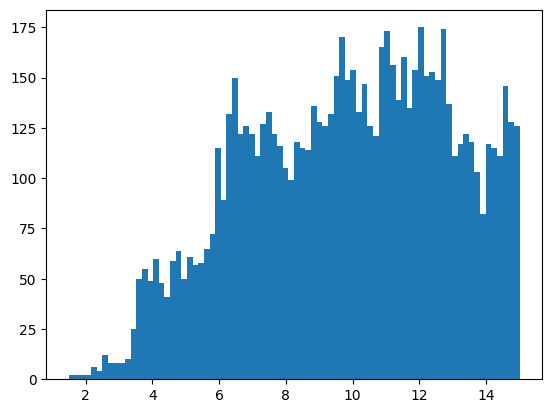

In [149]:
plt.hist(ttcs[ttcs<15].cpu().numpy(), bins=80)